In [1]:
#@title Install dependencies
%%capture
!pip install geopandas
!pip install scikeras
!pip install mapclassify
!pip install contextily

In [2]:
#@title Import libs
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import time
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import pickle


# Function definitions

In [74]:
def gen_points(tl, tr, bl, br, N):
  assert(tl.y == tr.y)

  tline_points = [Point(x, tl.y) for x in np.linspace(tl.x, tr.x, N)]

  assert(bl.y == br.y)
  bline_points = [Point(x, bl.y) for x in np.linspace(bl.x, br.x, N)]

  vpoints = []
  for t,b in zip(tline_points, bline_points):
      assert(t.x == b.x)
      vline_points = [Point(t.x, y) for y in np.linspace(t.y, b.y, N)]
      for v in vline_points:
          if v not in tline_points and v not in bline_points :
              vpoints.append(v)
  return np.concatenate([tline_points, bline_points, vpoints], axis=None), tline_points, bline_points, vpoints

def prepare_data(s, d):
  u_x = [i.x for i in d]
  u_y = [i.y for i in d]

  gis_x = [i.x for i in s]
  gis_y = [i.y for i in s]

  X = pd.DataFrame({'gis_x': gis_x, 'gis_y': gis_y})
  y = pd.DataFrame({'u_x': u_x, 'u_y': u_y})

  X = X.loc[:, ['gis_x','gis_y']].values
  y = y.loc[:, ['u_x','u_y']].values
  return X, y

# Example for generating points for $N=10$
This example follows the running example for Mina.

|              |             GIS (lat,long)            | Unity 3D Engine (x,y) |
|-------------:|:-------------------------------------:|:---------------------:|
|     Top-left | $(21.3871803517162, 39.914469580065)$ |        $(0,4750($        |
| Bottom-right |  $(21.4300499951713, 39.8638090805479)$ |     $(5250,0)$    |

In [75]:
gis_tl = Point(39.914469580065, 21.3871803517162)
gis_br = Point(39.8638090805479, 21.4300499951713)
gis_tr = Point(39.914469580065, 21.4300499951713)
gis_bl = Point(39.8638090805479, 21.3871803517162)

unity_tl = Point(0,4750)
unity_br = Point(5250,0)
unity_tr = Point(5250,4750)
unity_bl = Point(0,0)

# GIS and Unity plots

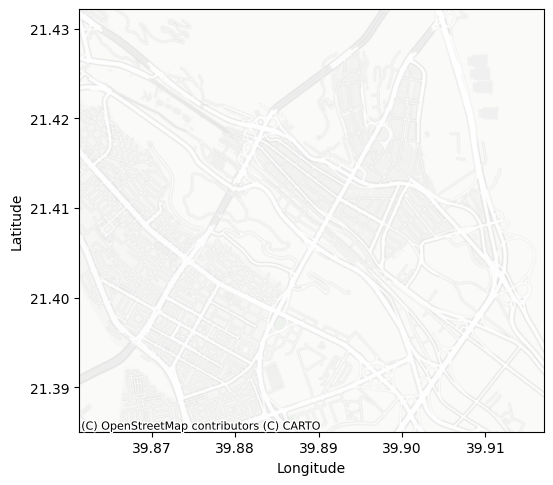

,geometry
0,"POLYGON ((39.86381 21.38718, 39.91447 21.38718..."


In [76]:
#@title Plot Mina MBR

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as ctx

# Define the MBR coordinates
maxy, minx =  (21.4300499951713, 39.8638090805479)
miny, maxx = (21.3871803517162, 39.914469580065)



# Create a Polygon representing the MBR
polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)])

# Create a GeoDataFrame from the Polygon
gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs="EPSG:4326")  # Use appropriate CRS


# Assuming 'cx' and 'cy' are the center coordinates for the plot
# You'll need to replace these with your actual desired center
cx = (minx + maxx) / 2
cy = (miny + maxy) / 2

# Plot the MBR on a map using contextily
ax = gdf.plot(figsize=(6, 6), alpha=0.0, edgecolor='k')
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.PositronNoLabels) # use appropriate CRS

# Set plot limits (optional)
# ax.set_xlim(minx - 0.01, maxx + 0.01) # adjust the 0.01 value for better visualization
# ax.set_ylim(miny - 0.01, maxy + 0.01)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('mbr.pdf')
plt.show()
# explore and plot points as pin markers and plot ploygon normally
gdf

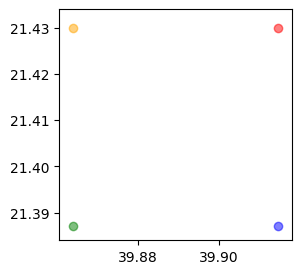

In [47]:
plt.figure(figsize=(3,3))

plt.plot(gis_tl.x, gis_tl.y, 'o', color='blue' , label='Top_left' , alpha=0.5)
plt.plot(gis_tr.x, gis_tr.y, 'o', color='red' , label='Top_right' , alpha=0.5)
plt.plot(gis_bl.x, gis_bl.y, 'o', color='green' , label='Bottom_left' , alpha=0.5)
plt.plot(gis_br.x, gis_br.y, 'o', color='orange' , label='Bottom_right' , alpha=0.5)

plt.ylim(21.384,21.434)
plt.xlim(39.8605, 39.918)

# plt.legend()
plt.savefig('seed-gis-vis.pdf', bbox_inches='tight')
plt.show()

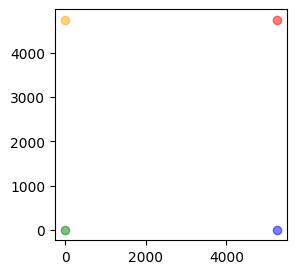

In [48]:
plt.figure(figsize=(3,3))

plt.plot(unity_tl.x, unity_tl.y, 'o', color='orange' , label='Top_left' , alpha=0.5)
plt.plot(unity_tr.x, unity_tr.y, 'o', color='red' , label='Top_right' , alpha=0.5)
plt.plot(unity_bl.x, unity_bl.y, 'o', color='green' , label='Bottom_left' , alpha=0.5)
plt.plot(unity_br.x, unity_br.y, 'o', color='blue' , label='Bottom_right' , alpha=0.5)

plt.savefig('seed-unity-vis.pdf', bbox_inches='tight')
plt.show()

## Step-wise visualization of the Generation Algorithm

In [59]:
N=10
unity_output, unity_tline_points, unity_bline_points, unity_vpoints = gen_points(unity_tl, unity_tr, unity_bl, unity_br, N)

POINT (0 4750), POINT (5250 4750)


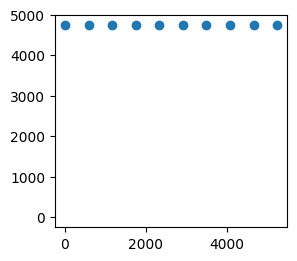

In [60]:
unity_tline_points = gpd.GeoSeries(unity_tline_points)
unity_tline_points.plot(figsize=(3,3))

plt.xlim(-250, 5500)
plt.ylim(-250,5000)
plt.savefig('alg-gen-s1.pdf', bbox_inches='tight')

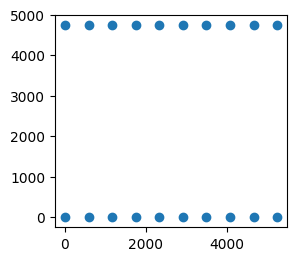

In [61]:
unity_bline_points = gpd.GeoSeries(np.concatenate([unity_tline_points, unity_bline_points], axis=None))
unity_bline_points.plot(figsize=(3,3))

plt.xlim(-250, 5500)
plt.ylim(-250,5000)

plt.savefig('alg-gen-s2.pdf', bbox_inches='tight')

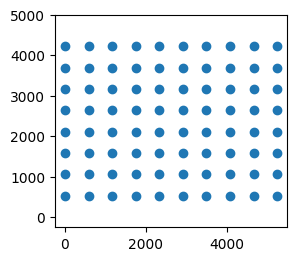

In [62]:
unity_vpoints = gpd.GeoSeries(unity_vpoints)
unity_vpoints.plot(figsize=(3,3))
plt.xlim(-250, 5500)
plt.ylim(-250,5000)
plt.savefig('alg-gen-s3.pdf', bbox_inches='tight')

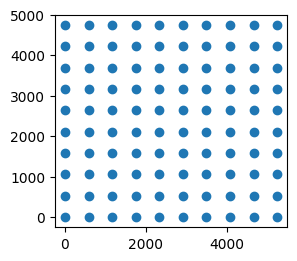

In [63]:
unity_output = gpd.GeoSeries(unity_output)
unity_output.plot(figsize=(3,3))
plt.xlim(-250, 5500)
plt.ylim(-250, 5000)
plt.savefig('alg-gen-s3.pdf', bbox_inches='tight')

# Generating output and preparing dataset

In [73]:
N = 10
unity_output, unity_tline_points, unity_bline_points, unity_vpoints = gen_points(unity_tl, unity_tr, unity_bl, unity_br, N)
gis_output, gis_tline_points, gis_bline_points, gis_vpoints = gen_points(gis_tl, gis_bl, gis_tr, gis_br, N)
X, y = prepare_data(unity_output, gis_output)

POINT (0 4750), POINT (5250 4750)
POINT (39.914469580065 21.3871803517162), POINT (39.8638090805479 21.3871803517162)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

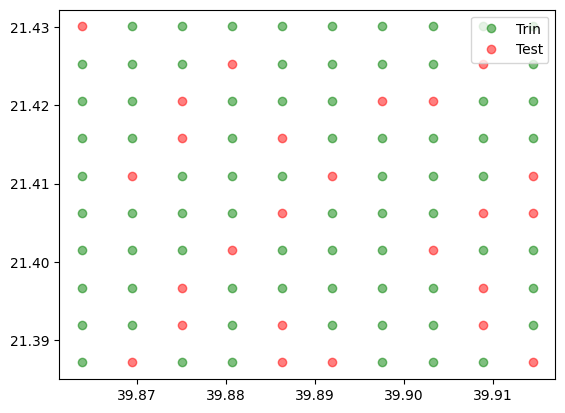

In [72]:
plt.plot(y_train[:,0],y_train[:,1], 'o', color='green' , label='Trin' , alpha=0.5)
plt.plot(y_test[:,0],y_test[:,1], 'o', color='red' , label='Test' , alpha=0.5)
plt.legend()
plt.show()